In [1]:
import random
from sklearn.utils.extmath import row_norms
from sklearn.utils.extmath import row_norms, squared_norm, stable_cumsum
import scipy.sparse as sp
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.datasets.samples_generator import make_blobs
import cv2 as cv
from fuzzy_cmeans import FCM 
import PsnrSnr as p
np.random.seed(0)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


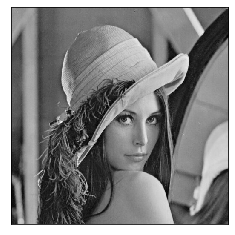

In [2]:
img = cv.imread("../lena_gray.jpg", 0)
size=512
img = cv.resize(img, dsize=(size, size)) 
width=img.shape[0]
height=img.shape[1]

plt.imshow(img, cmap="gray")
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.show()


In [3]:
i = 0
j = 0
luv = []

for h in range(int(width / 2)):
    j = 0
    for k in range(int(height / 2)):
        luv.append([img[i, j], img[i + 1, j], img[i, j + 1], img[i + 1, j + 1]])
        j = j + 2
    i = i + 2
    
x=np.array(luv)

In [4]:
def _k_init(X, n_clusters, x_squared_norms, random_state, n_local_trials=None):
    """Init n_clusters seeds according to k-means++
    Parameters
    ----------
    X : array or sparse matrix, shape (n_samples, n_features)
        The data to pick seeds for. To avoid memory copy, the input data
        should be double precision (dtype=np.float64).
    n_clusters : integer
        The number of seeds to choose
    x_squared_norms : array, shape (n_samples,)
        Squared Euclidean norm of each data point.
    random_state : int, RandomState instance
        The generator used to initialize the centers. Use an int to make the
        randomness deterministic.
        See :term:`Glossary <random_state>`.
    n_local_trials : integer, optional
        The number of seeding trials for each center (except the first),
        of which the one reducing inertia the most is greedily chosen.
        Set to None to make the number of trials depend logarithmically
        on the number of seeds (2+log(k)); this is the default.
    Notes
    -----
    Selects initial cluster centers for k-mean clustering in a smart way
    to speed up convergence. see: Arthur, D. and Vassilvitskii, S.
    "k-means++: the advantages of careful seeding". ACM-SIAM symposium
    on Discrete algorithms. 2007
    Version ported from http://www.stanford.edu/~darthur/kMeansppTest.zip,
    which is the implementation used in the aforementioned paper.
    """
    n_samples, n_features = X.shape

    centers = np.empty((n_clusters, n_features), dtype=X.dtype)

    assert x_squared_norms is not None, 'x_squared_norms None in _k_init'

    # Set the number of local seeding trials if none is given
    if n_local_trials is None:
        # This is what Arthur/Vassilvitskii tried, but did not report
        # specific results for other than mentioning in the conclusion
        # that it helped.
        n_local_trials = 2 + int(np.log(n_clusters))

    # Pick first center randomly
    center_id = random_state.randint(n_samples)
    if sp.issparse(X):
        centers[0] = X[center_id].toarray()
    else:
        centers[0] = X[center_id]

    # Initialize list of closest distances and calculate current potential
    closest_dist_sq = euclidean_distances(
        centers[0, np.newaxis], X, Y_norm_squared=x_squared_norms,
        squared=True)
    current_pot = closest_dist_sq.sum()

    # Pick the remaining n_clusters-1 points
    for c in range(1, n_clusters):
        # Choose center candidates by sampling with probability proportional
        # to the squared distance to the closest existing center
        rand_vals = random_state.random_sample(n_local_trials) * current_pot
        candidate_ids = np.searchsorted(stable_cumsum(closest_dist_sq),
                                        rand_vals)

        # Compute distances to center candidates
        distance_to_candidates = euclidean_distances(
            X[candidate_ids], X, Y_norm_squared=x_squared_norms, squared=True)

        # Decide which candidate is the best
        best_candidate = None
        best_pot = None
        best_dist_sq = None
        for trial in range(n_local_trials):
            # Compute potential when including center candidate
            new_dist_sq = np.minimum(closest_dist_sq,
                                     distance_to_candidates[trial])
            new_pot = new_dist_sq.sum()

            # Store result if it is the best local trial so far
            if (best_candidate is None) or (new_pot < best_pot):
                best_candidate = candidate_ids[trial]
                best_pot = new_pot
                best_dist_sq = new_dist_sq

        # Permanently add best center candidate found in local tries
        if sp.issparse(X):
            centers[c] = X[best_candidate].toarray()
        else:
            centers[c] = X[best_candidate]
        current_pot = best_pot
        closest_dist_sq = best_dist_sq

    return centers

In [5]:
import time as t

cluster = 12

clusterssize = [cluster]  # 2, 3, 4, 5, 6, 7, 8, 9,
timearray = []
psnrarray = []
segementedImg = []

In [6]:
for i in range(10):
    
    start=t.time()
    randomnumber = np.random.randint(0, 100)
    print(randomnumber)
    fuzzy_cmeans2 = FCM(n_clusters=cluster,max_iter=50,m=3) 
    fuzzy_cmeans2.fit(x)    
    timearray.append(t.time()-start)
    label=fuzzy_cmeans2.predict(x)

    pic2show = fuzzy_cmeans2.centers[label] 
    print(timearray)
    
    centersp = (fuzzy_cmeans2.centers[label]).reshape(
        int(width / 2), int(height / 2), 4
    )


    temp = np.zeros((width, height))
    i = 0
    j = 0
    for h in range(int(width / 2)):
        j = 0
        for k in range(int(height / 2)):
            val = centersp

            temp[i, j] = val[h][k][0]
            temp[i + 1, j] = val[h][k][1]
            temp[i, j + 1] = val[h][k][2]
            temp[i + 1, j + 1] = val[h][k][3]

            j = j + 2
        i = i + 2

    psnr = p.psnr(np.array(img).astype(int), np.array(temp).astype(int))
    psnrarray.append(psnr)

44
[7.434700965881348]
25
[7.434700965881348, 7.398860216140747]
41
[7.434700965881348, 7.398860216140747, 7.084794759750366]
80
[7.434700965881348, 7.398860216140747, 7.084794759750366, 7.057860374450684]
21
[7.434700965881348, 7.398860216140747, 7.084794759750366, 7.057860374450684, 7.203679323196411]
30
[7.434700965881348, 7.398860216140747, 7.084794759750366, 7.057860374450684, 7.203679323196411, 7.319591522216797]
86
[7.434700965881348, 7.398860216140747, 7.084794759750366, 7.057860374450684, 7.203679323196411, 7.319591522216797, 7.059844255447388]
13
[7.434700965881348, 7.398860216140747, 7.084794759750366, 7.057860374450684, 7.203679323196411, 7.319591522216797, 7.059844255447388, 7.0896382331848145]
8
[7.434700965881348, 7.398860216140747, 7.084794759750366, 7.057860374450684, 7.203679323196411, 7.319591522216797, 7.059844255447388, 7.0896382331848145, 7.067857980728149]
66
[7.434700965881348, 7.398860216140747, 7.084794759750366, 7.057860374450684, 7.203679323196411, 7.3195915

In [7]:
print("PSNR", np.mean(psnrarray), "+/- \n", np.std(psnrarray))
print("timearray", np.mean(timearray), "+/- \n", np.std(timearray))

PSNR 29.2602903018107 +/- 
 0.05970866581196743
timearray 7.180787420272827 +/- 
 0.14138104610710572
